In [ ]:
!pip install liwc
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# **Leer LIWC diccionario - Español**

In [ ]:
import liwc

In [ ]:
liwcPath= r'/content/drive/MyDrive/Experimentación Python Tesis /Diccionarios español/Spanish_LIWC2007_Dictionary.dic'
parse, category_names = liwc.load_token_parser(liwcPath)
print(f'Categorias del diccionario: {category_names}')

Categorias del diccionario: ['Funct', 'TotPron', 'PronPer', 'Yo', 'Nosotro', 'TuUtd', 'ElElla', 'Ellos', 'PronImp', 'Articulo', 'Verbos', 'VerbAux', 'Pasado', 'Present', 'Futuro', 'Adverb', 'Prepos', 'Conjunc', 'Negacio', 'Cuantif', 'Numeros', 'Maldec', 'verbYO', 'verbTU', 'verbNOS', 'verbosEL', 'verbELLOS', 'Subjuntiv', 'VosUtds', 'formal', 'informal', 'verbVos', 'Social', 'Familia', 'Amigos', 'Humanos', 'Afect', 'EmoPos', 'EmoNeg', 'Ansiedad', 'Enfado', 'Triste', 'MecCog', 'Insight', 'Causa', 'Discrep', 'Tentat', 'Certeza', 'Inhib', 'Incl', 'Excl', 'Percept', 'Ver', 'Oir', 'Sentir', 'Biolog', 'Cuerpo', 'Salud', 'Sexual', 'Ingerir', 'Relativ', 'Movim', 'Espacio', 'Tiempo', 'Trabajo', 'Logro', 'Placer', 'Hogar', 'Dinero', 'Relig', 'Muerte', 'Asentir', 'NoFluen', 'Relleno']


# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1



In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263950 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 109


In [ ]:
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)
data_train.info()

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 263841 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263841 non-null  object 
 1   TWEET_ID    263841 non-null  float64
 2   TWEET_TEXT  263841 non-null  object 
 3   trastorno   263841 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ MB


# **limpiar Dataset**

In [ ]:
import re
import string


def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'https', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)
    text = re.sub(r'[^\w\s]+', '', text)
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                  '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                  ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')
    return text


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : clean(x))

**Remover Stopword**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def Stopword(text):
  token_text = nltk.word_tokenize(text)
  remover_palab = [word for word in token_text if word not in stopwords_en]
  join_text = ' '.join(remover_palab)
  return join_text

In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : Stopword(x))

**Lemmatización**

In [ ]:
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Me gustan los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gustar', 'gato', 'saltar', 'valla']


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : extractTerms(x))

# **Usar LIWC para extraer las caracteristicas del texto**

In [ ]:
corpus = []
words = []

for i in range(0,len(data_train)):
    review = re.sub('[^a-zA-Z0-9]',' ',data_train['TWEET_TEXT'][i])
    review = review.lower()
    review = review.split()
    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)


# **Metodo TfidfVectorizer**

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer=TfidfVectorizer(max_features=5000)
# X_fit=vectorizer.fit(corpus)
# X_transformed=X_fit.transform(corpus)
# features = vectorizer.get_feature_names_out()
# df_count = pd.DataFrame(X_transformed.toarray(),columns = features)
# df_count

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect  = TfidfVectorizer()

# Aplicar el TfidfVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz TF-IDF
tfidf_train  = tfidf_vect.fit_transform(corpus)
# Imprimir el tamaño del vocabulario construido por TfidfVectorizer
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

X = tfidf_train # Matriz TF-IDF
y = data_train['trastorno'].values # Etiquetas de trastorno de la columna 'trastorno'

features = tfidf_vect.get_feature_names_out()

df_count = pd.DataFrame(tfidf_train.toarray(),columns = features)
df_count

El tamaño del vocabulario es:  73


,adverb,afect,amigos,ansiedad,articulo,asentir,biolog,causa,certeza,conjunc,...,verbaux,verbellos,verbnos,verbos,verbosel,verbtu,verbvos,verbyo,vosutds,yo
0,0.000000,0.146914,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.267177,0.300631,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.500373,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.250684,0.000000,0.418274,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.144846,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263945,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.322844,0.000000,0.0,0.0,0.0,0.0,0.000000
263946,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
263947,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.532762
263948,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [ ]:
print(X.shape)
print(y.shape)

(263950, 73)
(263950,)


# **Dividir los datos de entrenamiento y prueba**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.optimizers import Adam

**Aplicar LDA para reducir la dimensionalidad**

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 10  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:
print("Dimensiones de X_train:", X_train_lda.shape)
print("Dimensiones de X_val:", X_test_lda.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_test.shape)

Dimensiones de X_train: (184765, 10)
Dimensiones de X_val: (79185, 10)
Dimensiones de y_train: (184765,)
Dimensiones de y_val: (79185,)


#**Aprendizaje del modelo: Red Neuronal simple**

In [ ]:
# Crear un modelo de red neuronal secuencial
model = Sequential()

input_dim = X_train_lda.shape[1]  # Obtener la dimensión de entrada
model.add(Dense(350, activation='relu', input_dim=input_dim))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Utilizar EarlyStopping para detener el entrenamiento si no hay mejora
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo en los datos de entrenamiento transformados por LDA
model.fit(X_train_lda, y_train, epochs=100, batch_size=200, verbose=1, validation_data=(X_test_lda, y_test), callbacks=[early_stopping])

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test_lda)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias (0 o 1)

# Calcular la precisión, recall y puntuación F1
accuracy = accuracy_score(y_test, y_pred_binary )
precision = precision_score(y_test, y_pred_binary, average='weighted')
recall = recall_score(y_test, y_pred_binary, average='weighted')
f1 = f1_score(y_test, y_pred_binary, average='weighted')
# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/modelo_entrenado_LDA_TFIDF_BoW_RN.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/modelo_entrenado_LDA_TFIDF_BoW_RN.h5')

Epoch 1/100
924/924 [==============================] - 10s 10ms/step - loss: 0.6612 - accuracy: 0.6027 - val_loss: 0.6589 - val_accuracy: 0.6071
Epoch 2/100
924/924 [==============================] - 6s 7ms/step - loss: 0.6588 - accuracy: 0.6068 - val_loss: 0.6583 - val_accuracy: 0.6072
Epoch 3/100
924/924 [==============================] - 9s 9ms/step - loss: 0.6578 - accuracy: 0.6073 - val_loss: 0.6586 - val_accuracy: 0.6064
Epoch 4/100
924/924 [==============================] - 7s 7ms/step - loss: 0.6569 - accuracy: 0.6076 - val_loss: 0.6571 - val_accuracy: 0.6063
Epoch 5/100
924/924 [==============================] - 8s 9ms/step - loss: 0.6564 - accuracy: 0.6083 - val_loss: 0.6566 - val_accuracy: 0.6089
Epoch 6/100
924/924 [==============================] - 7s 7ms/step - loss: 0.6559 - accuracy: 0.6094 - val_loss: 0.6558 - val_accuracy: 0.6089
Epoch 7/100
924/924 [==============================] - 8s 9ms/step - loss: 0.6557 - accuracy: 0.6096 - val_loss: 0.6554 - val_accuracy: 0.60

In [ ]:
print(f"Exactitud: {accuracy * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")

Exactitud: 61.42%
Precisión: 61.60%
Recall: 61.42%
Puntuación F1: 61.27%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2475/2475 [==============================] - 5s 2ms/step
Matriz de confusión: 

 [[21844 17738]
 [12813 26790]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.56


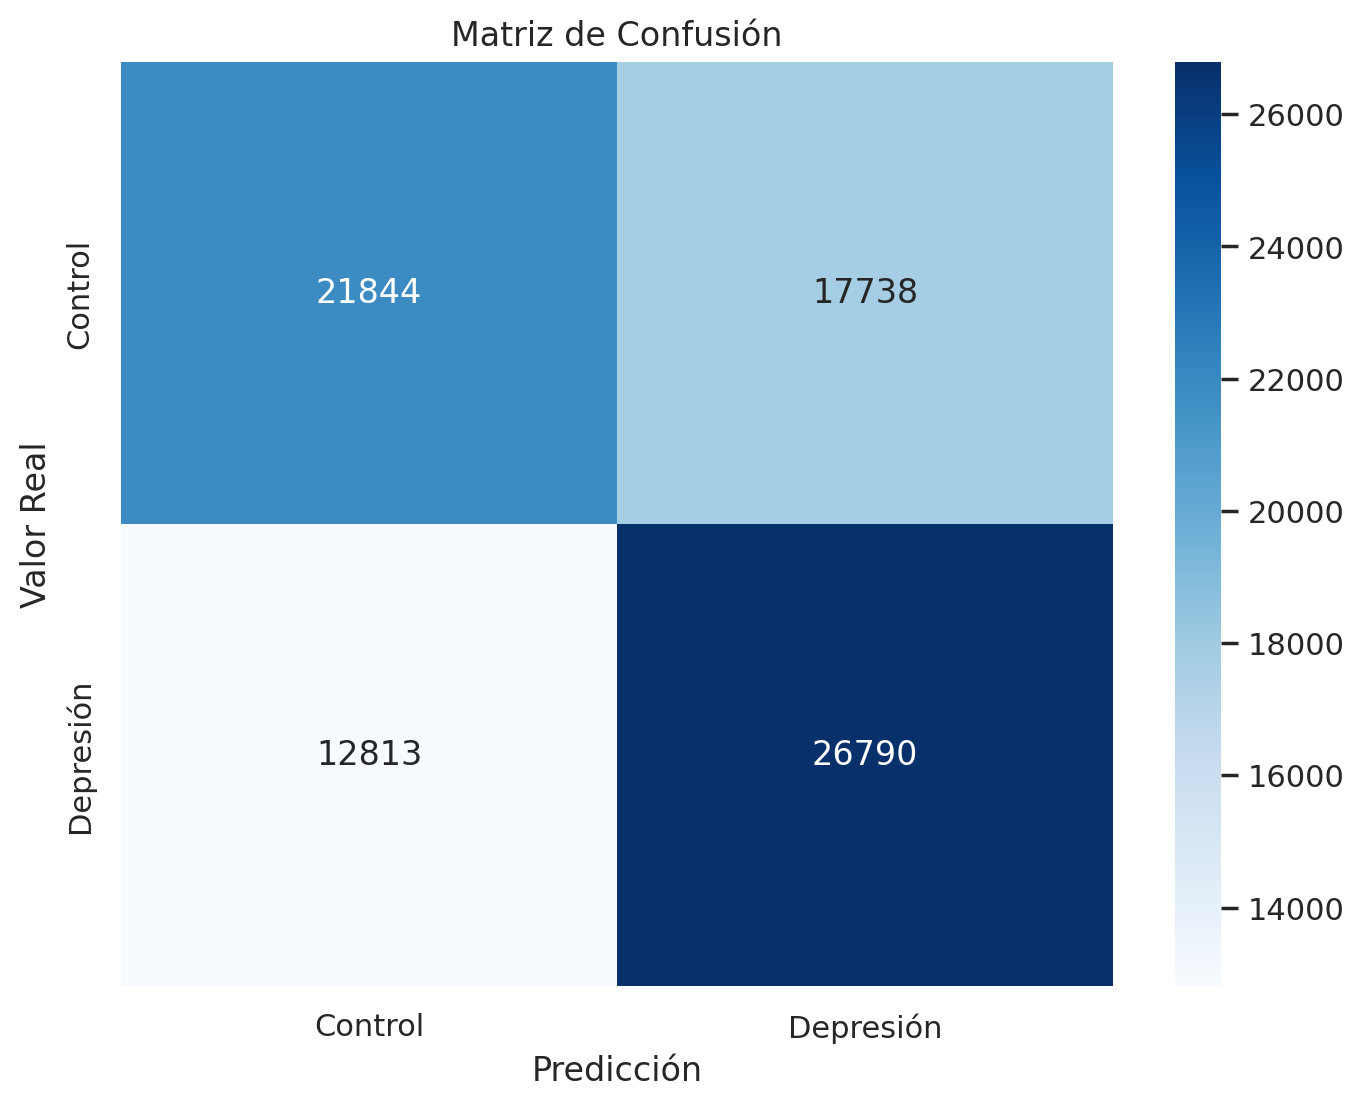

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Entrenamiento con validación cruzada k=10

In [ ]:
# Crear listas para almacenar las métricas de entrenamiento y validación
train_accuracy_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []
val_accuracy_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

# Crear un objeto StratifiedKFold para dividir los datos en k-folds estratificados
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for train_index, val_index in skf.split(X_train_lda, y_train):
    X_train_fold, X_val_fold = X_train_lda[train_index], X_train_lda[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    X_train = X_train_fold
    X_val = X_val_fold

    # Crear una red neuronal secuencial
    model = Sequential()
    model.add(Dense(328, activation='relu', input_dim=X_train_lda.shape[1]))
    model.add(Dropout(0.1))
    model.add(Dense(164, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))  # Cambio: una unidad y activación sigmoide
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train, y_train_fold, epochs=10, batch_size=32)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_pred_class = (y_train_pred > 0.5).astype(int).flatten()
    train_accuracy = accuracy_score(y_train_fold, y_train_pred_class)
    train_precision = precision_score(y_train_fold, y_train_pred_class)
    train_recall = recall_score(y_train_fold, y_train_pred_class)
    train_f1 = f1_score(y_train_fold, y_train_pred_class)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = model.predict(X_val)
    y_val_pred_class = (y_val_pred > 0.5).astype(int).flatten()
    val_accuracy = accuracy_score(y_val_fold, y_val_pred_class)
    val_precision = precision_score(y_val_fold, y_val_pred_class)
    val_recall = recall_score(y_val_fold, y_val_pred_class)
    val_f1 = f1_score(y_val_fold, y_val_pred_class)

    # Almacenar las métricas en las listas
    train_accuracy_list.append(train_accuracy)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_f1_list.append(train_f1)
    val_accuracy_list.append(val_accuracy)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)
    val_f1_list.append(val_f1)


# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/modelo_entrenado_LDA_LIWC_TFIDF_RN(k=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/modelo_entrenado_LDA_LIWC_TFIDF_RN(k=10).h5')

Epoch 1/10
5197/5197 [==============================] - 16s 3ms/step - loss: 0.6612 - accuracy: 0.6041
Epoch 2/10
5197/5197 [==============================] - 15s 3ms/step - loss: 0.6587 - accuracy: 0.6063
Epoch 3/10
5197/5197 [==============================] - 19s 4ms/step - loss: 0.6576 - accuracy: 0.6076
Epoch 4/10
5197/5197 [==============================] - 16s 3ms/step - loss: 0.6570 - accuracy: 0.6079
Epoch 5/10
5197/5197 [==============================] - 15s 3ms/step - loss: 0.6564 - accuracy: 0.6088
Epoch 6/10
5197/5197 [==============================] - 15s 3ms/step - loss: 0.6564 - accuracy: 0.6083
Epoch 7/10
5197/5197 [==============================] - 15s 3ms/step - loss: 0.6560 - accuracy: 0.6090
Epoch 8/10
5197/5197 [==============================] - 22s 4ms/step - loss: 0.6558 - accuracy: 0.6104
Epoch 9/10
5197/5197 [==============================] - 18s 3ms/step - loss: 0.6556 - accuracy: 0.6098
Epoch 10/10
578/578 [==============================] - 1s 2ms/step
Epoch 

In [ ]:
print(f"Entrenemiento Accuracy: {train_accuracy* 100:.2f}%")
print(f"ntrenemiento Precision: {train_precision* 100:.2f}%")
print(f"ntrenemiento Recall: {train_recall* 100:.2f}%")
print(f"ntrenemiento F1 Score: {train_f1* 100:.2f}%")
print('-'*100)

print(f"Validación Accuracy: {val_accuracy* 100:.2f}%")
print(f"Validación Precision: {val_precision* 100:.2f}%")
print(f"Validación Recall: {val_recall* 100:.2f}%")
print(f"Validación F1 Score: {val_f1* 100:.2f}%")

Entrenemiento Accuracy: 61.17%
ntrenemiento Precision: 60.11%
ntrenemiento Recall: 66.67%
ntrenemiento F1 Score: 63.22%
----------------------------------------------------------------------------------------------------
Validación Accuracy: 60.30%
Validación Precision: 59.32%
Validación Recall: 65.81%
Validación F1 Score: 62.40%


In [ ]:
from sklearn.metrics import confusion_matrix
with tf.device('/device:CPU:0'):
  y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_fold, y_pred_binario)
prop_real = np.sum(y_val_fold)/len(y_val_fold)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_fold)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

578/578 [==============================] - 1s 1ms/step
Matriz de confusión: 

 [[5055 4173]
 [3162 6086]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.56


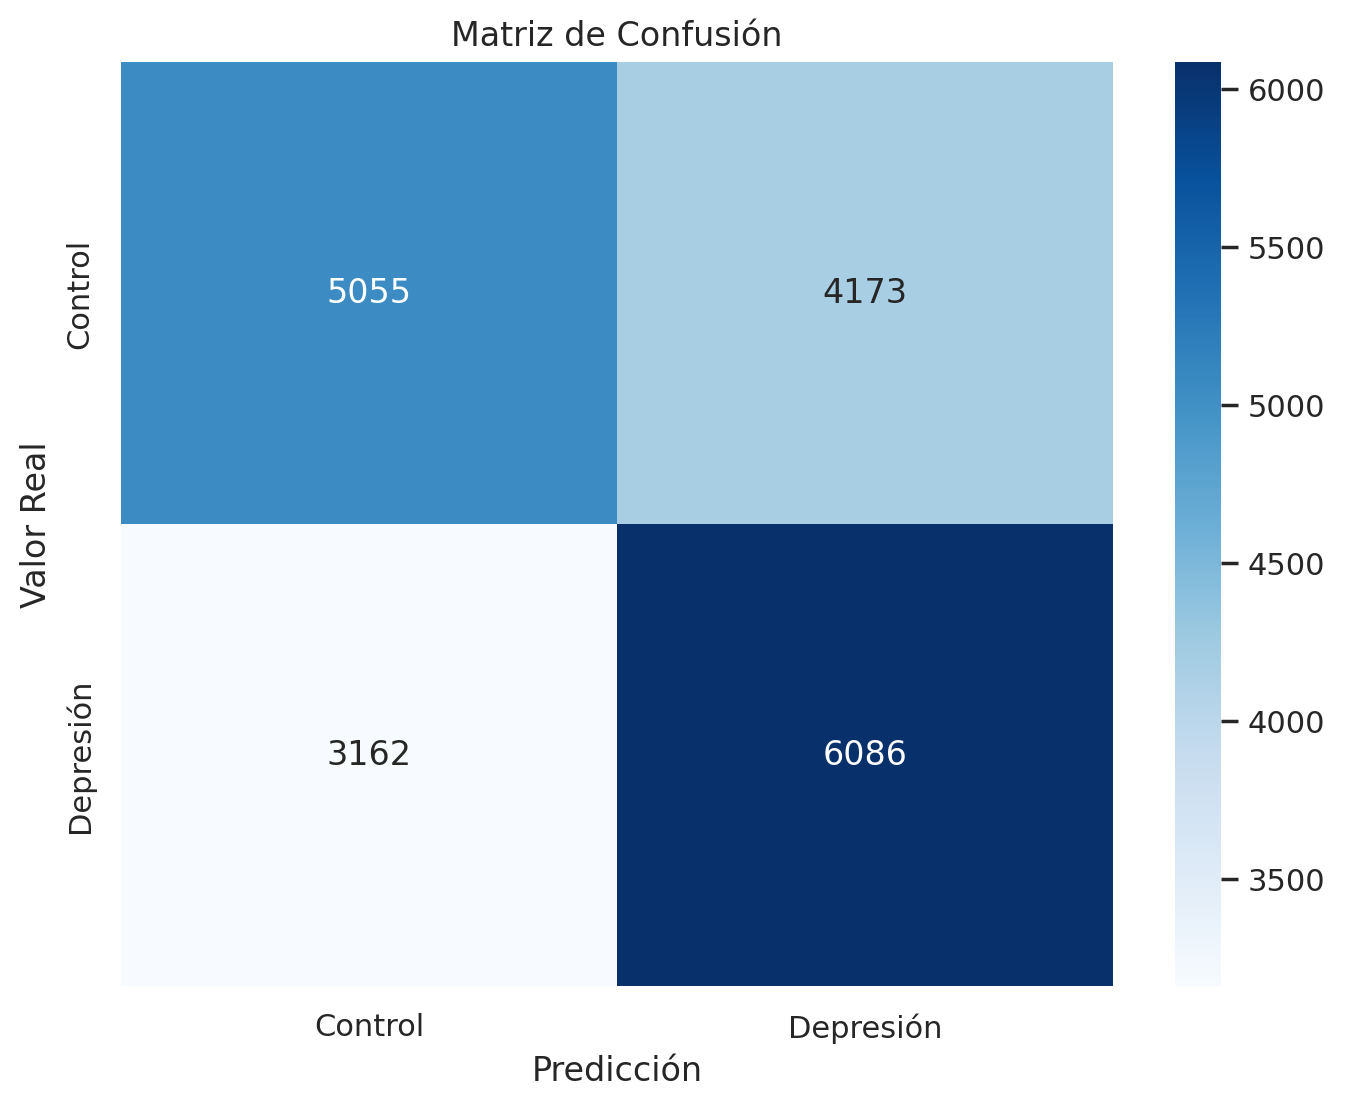

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2'
model_filename = 'TWEETS_depresivos LDA, LIWC y TFIDF (RN-CV=10).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/TWEETS_depresivos LDA, LIWC y TFIDF (RN-CV=10).pkl']